In [1]:
from typing import TypedDict, List, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import MemorySaver
from langsmith import traceable

In [2]:
load_dotenv(override=True)
llm = init_chat_model(model="gpt-4o-mini")
memory = MemorySaver()

In [3]:
class State(TypedDict):
    messages: Annotated[List, add_messages]

In [ ]:
def chatbot(state: State)->State:
    return {"messages": [llm.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
message = {"role":"user", "content":"Who was the first person on the moon? Only name"}
response = graph.invoke({"messages": [message]})

In [ ]:
print(response)
print(response['messages'][1])

In [ ]:
state=None
while True:
    in_message = input("")
    if in_message.lower() in ["exit", "quit"]:
        break

    if state is None:
        state: State = {
            "messages": [{"role":"user", "content": in_message}]
        }
    else:
        state["messages"].append({"role":"user", "content":in_message})
    
    state = graph.invoke(state)
    print("BOT:", state["messages"][-1].content)

In [ ]:
@tool("get_stock_price", description="Return a mock stock price for the given COMPANY NAME.")
def get_stock_price(company_name: str)->float:
    stock_symbols = {"Microsoft": 250.2, "Apple": 350.5, "Google": 500.0, "Amazon": 400.7}

    return stock_symbols.get(company_name, 0.0)

@tool("buy_stock", description="Buy a stock after approving (yes) or decline (no) a stock.")
def buy_stock(symbol: str, quantity: int, total_price: float)->str:
    decision = interrupt(f"Approve buying {symbol} {quantity} stocks for price ${total_price: .2f}?")

    if decision == "yes":
        return f"You bought {quantity} shares of {symbol} for a total price of {total_price}"
    else:
        return "Buying declined"

list_of_tools = [get_stock_price, buy_stock]

llm_with_tools = llm.bind_tools(tools=list_of_tools)

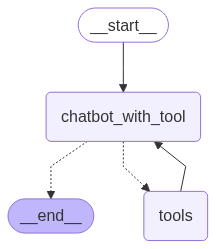

In [5]:
def chatbot_with_tool(state: State)->State:
    msg = llm_with_tools.invoke(state["messages"])
    return {"messages": [msg]}

builder = StateGraph(State)
builder.add_node("chatbot_with_tool", chatbot_with_tool)
builder.add_node("tools", ToolNode(list_of_tools))
builder.add_edge(START, "chatbot_with_tool")
builder.add_conditional_edges("chatbot_with_tool", tools_condition)
builder.add_edge("tools", "chatbot_with_tool")
builder.add_edge("chatbot_with_tool", END)

graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))



In [6]:
config1 = {
        "configurable": {"thread_id": "buy_thread"},
        "run_name": "chatbot_graph",
        "tags": ["langgraph", "tool-call"]
    }

In [ ]:
message = {"role":"user", "content":"What is the stock price of Apple? Give me the total price of 5 stocks."}
response= graph.invoke({"messages": [message]}, config= config1)
response['messages']

In [ ]:
message = {"role":"user", "content":"What is the stock price of Google? Add it to the previous total."}
response = graph.invoke({"messages": [message]}, config=config1)
response['messages']

In [11]:
@traceable
def get_response_from_llm(query: str):
    message = {"role": "user", "content": query}
    state = graph.invoke({"messages": [message]}, config=config1)

    if "__interrupt__" in state:
        decision = input("Approve (yes/no): ").strip().lower()
        state = graph.invoke(Command(resume=decision), config=config1)

    return state['messages'][-1].content

In [9]:
get_response_from_llm("What is stock price of Microsoft? Remove it from the previous total.")

[HumanMessage(content='Buy 15 stocks of Apple at current price.', additional_kwargs={}, response_metadata={}, id='35bf20c1-db63-433c-8eff-2ea1f0e86622'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AHBTYiymqMCuDNSEG38r5Art', 'function': {'arguments': '{"company_name":"Apple"}', 'name': 'get_stock_price'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 99, 'total_tokens': 115, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Boy9kcSyVlBvIhf1UXVWpkjpK48Fj', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e6766910-a61e-4309-9afd-906516e4c19c-0', tool_calls=[{'name': 'get_stock_price', 'args': {'company_name': 

In [12]:
get_response_from_llm("Buy 15 stocks of Apple at current price.")

'You successfully bought 15 shares of Apple (AAPL) for a total price of $5,257.50.'